# 기업 디폴트 리스크 스코어링 시스템: 재무 데이터 기반 조기 경보 플랫폼

## EDA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import RobustScaler

In [212]:
# 열 이름 매핑 사전
col_mapping = {
    'X1':  'Current_Assets',
    'X2':  'Cost_of_Goods_Sold',
    'X3':  'Depreciation',
    'X4':  'EBITDA',
    'X5':  'Inventory',
    'X6':  'Net_Income',
    'X7':  'Accounts_Receivable',
    'X8':  'Market_Capitalization',
    'X9':  'Net_Sales',
    'X10': 'Total_Assets',
    'X11': 'Long_Term_Debt',
    'X12': 'EBIT',
    'X13': 'Gross_Profit',
    'X14': 'Current_Liabilities',
    'X15': 'Retained_Earnings',
    'X16': 'Total_Revenue',
    'X17': 'Total_Liabilities',
    'X18': 'Operating_Expenses',
}

In [214]:
# 1) 데이터 로드 및 기본 확인
df = pd.read_csv('./american_bankruptcy.csv')
df.rename(columns=col_mapping, inplace=True)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78682 entries, 0 to 78681
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   company_name           78682 non-null  object 
 1   status_label           78682 non-null  object 
 2   year                   78682 non-null  int64  
 3   Current_Assets         78682 non-null  float64
 4   Cost_of_Goods_Sold     78682 non-null  float64
 5   Depreciation           78682 non-null  float64
 6   EBITDA                 78682 non-null  float64
 7   Inventory              78682 non-null  float64
 8   Net_Income             78682 non-null  float64
 9   Accounts_Receivable    78682 non-null  float64
 10  Market_Capitalization  78682 non-null  float64
 11  Net_Sales              78682 non-null  float64
 12  Total_Assets           78682 non-null  float64
 13  Long_Term_Debt         78682 non-null  float64
 14  EBIT                   78682 non-null  float64
 15  Gr

,year,Current_Assets,Cost_of_Goods_Sold,Depreciation,EBITDA,Inventory,Net_Income,Accounts_Receivable,Market_Capitalization,Net_Sales,Total_Assets,Long_Term_Debt,EBIT,Gross_Profit,Current_Liabilities,Retained_Earnings,Total_Revenue,Total_Liabilities,Operating_Expenses
count,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,7.868200e+04,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000
mean,2007.506317,880.362485,1594.529029,121.234256,376.759424,201.605717,129.382453,286.832743,3.414355e+03,2364.019706,2867.110620,722.483710,255.525035,769.490783,610.072255,532.467069,2364.019706,1773.563963,1987.260307
std,5.742768,3928.564794,8930.484664,652.376804,2012.023142,1060.766096,1265.532022,1335.978571,1.841410e+04,11950.068842,12917.944421,3242.170946,1494.643534,3774.703114,2938.387443,6369.159440,11950.068842,8053.684902,10419.629038
min,1999.000000,-7.760000,-366.645000,0.000000,-21913.000000,0.000000,-98696.000000,-0.006000,1.000000e-04,-1964.999000,0.001000,-0.023000,-25913.000000,-21536.000000,0.001000,-102362.000000,-1964.999000,0.001000,-317.197000
25%,2002.000000,18.924000,17.038250,1.192000,-0.811000,0.000000,-7.415750,3.281250,3.498000e+01,27.548500,37.363500,0.000000,-2.787000,8.521250,8.889250,-68.282750,27.548500,13.486000,32.872500
50%,2007.000000,100.449500,103.661000,7.929500,15.034500,7.023000,1.616000,22.820000,2.275118e+02,186.598500,213.203500,7.593500,6.518000,63.581500,43.333000,-1.131000,186.598500,81.988000,168.912000
75%,2012.000000,431.526750,634.548000,47.971750,139.655250,74.747250,40.144250,131.580500,1.244890e+03,1046.402500,1171.364750,248.760750,87.599000,344.074250,222.817000,146.070000,1046.402500,629.975000,875.522250
max,2018.000000,169662.000000,374623.000000,28430.000000,81730.000000,62567.000000,104821.000000,65812.000000,1.073391e+06,511729.000000,531864.000000,166250.000000,71230.000000,137106.000000,116866.000000,402089.000000,511729.000000,337980.000000,481580.000000


In [25]:
# 2) 연도(year) 컬럼 datetime 변환 (optional)
df['year'] = pd.to_datetime(df['year'], format='%Y')

In [27]:
# 3) 상태 라벨 → 이진 타깃 생성
#   'failed' → 1, 'alive' → 0
df['default'] = df['status_label'].map({'failed':1, 'alive':0})

In [29]:
# 4) 결측치 검토
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing values:\n", missing[missing > 0])

Missing values:
 Series([], dtype: int64)


Default rate (%):
default
0    93.3657
1     6.6343
Name: proportion, dtype: float64


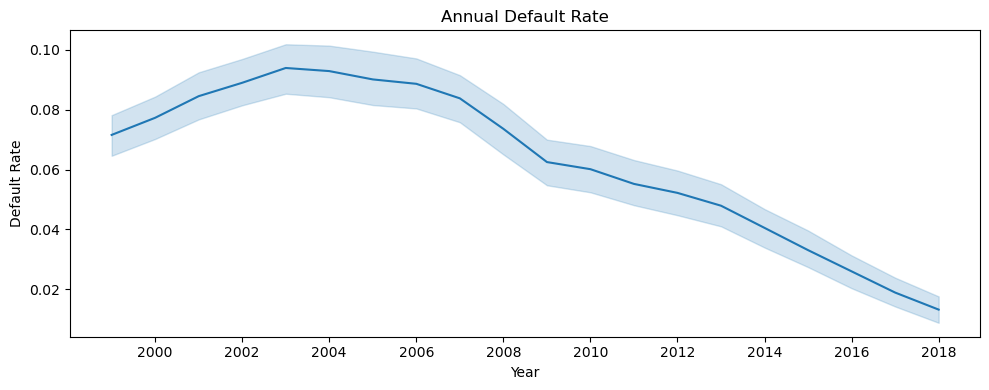

In [31]:
# 5) 타깃 분포 분석 (부도율)
print("Default rate (%):")
print(df['default'].value_counts(normalize=True) * 100)

# 연도별 부도율
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='year', y='default', estimator='mean')
plt.title('Annual Default Rate')
plt.ylabel('Default Rate')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

<Figure size 1200x1200 with 0 Axes>

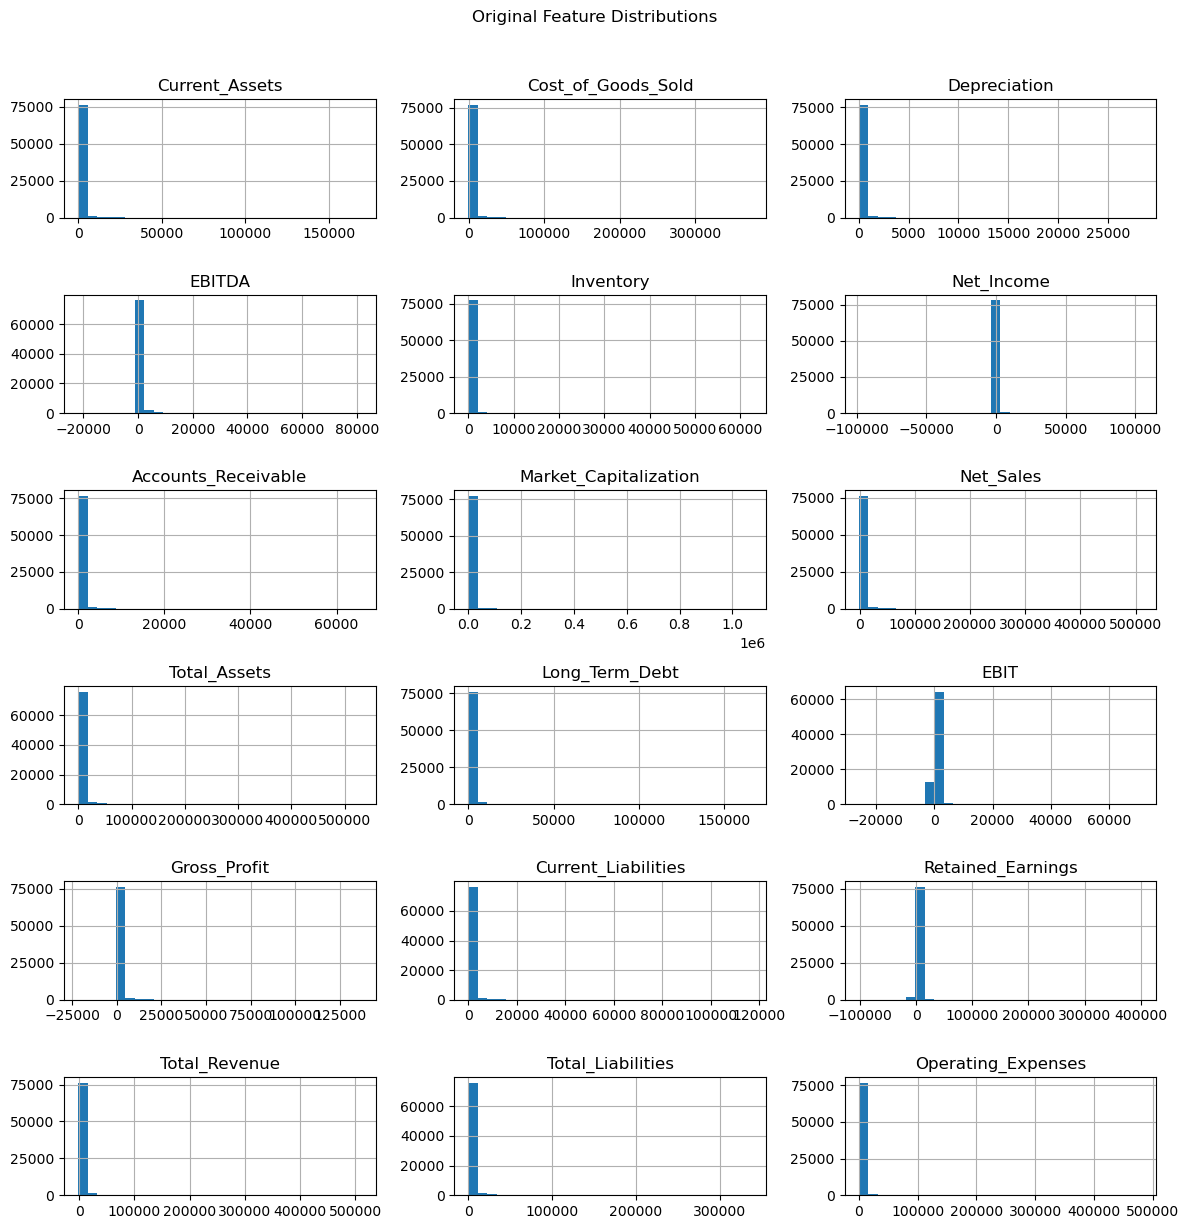

In [32]:
# 5) 원본 피처 분포 히스토그램
features = list(col_mapping.values())
plt.figure(figsize=(12,12))
df[features].hist(bins=30, layout=(6,3), figsize=(12,12))
plt.suptitle('Original Feature Distributions', y=1.02)
plt.tight_layout()
plt.show()

<Figure size 1200x1200 with 0 Axes>

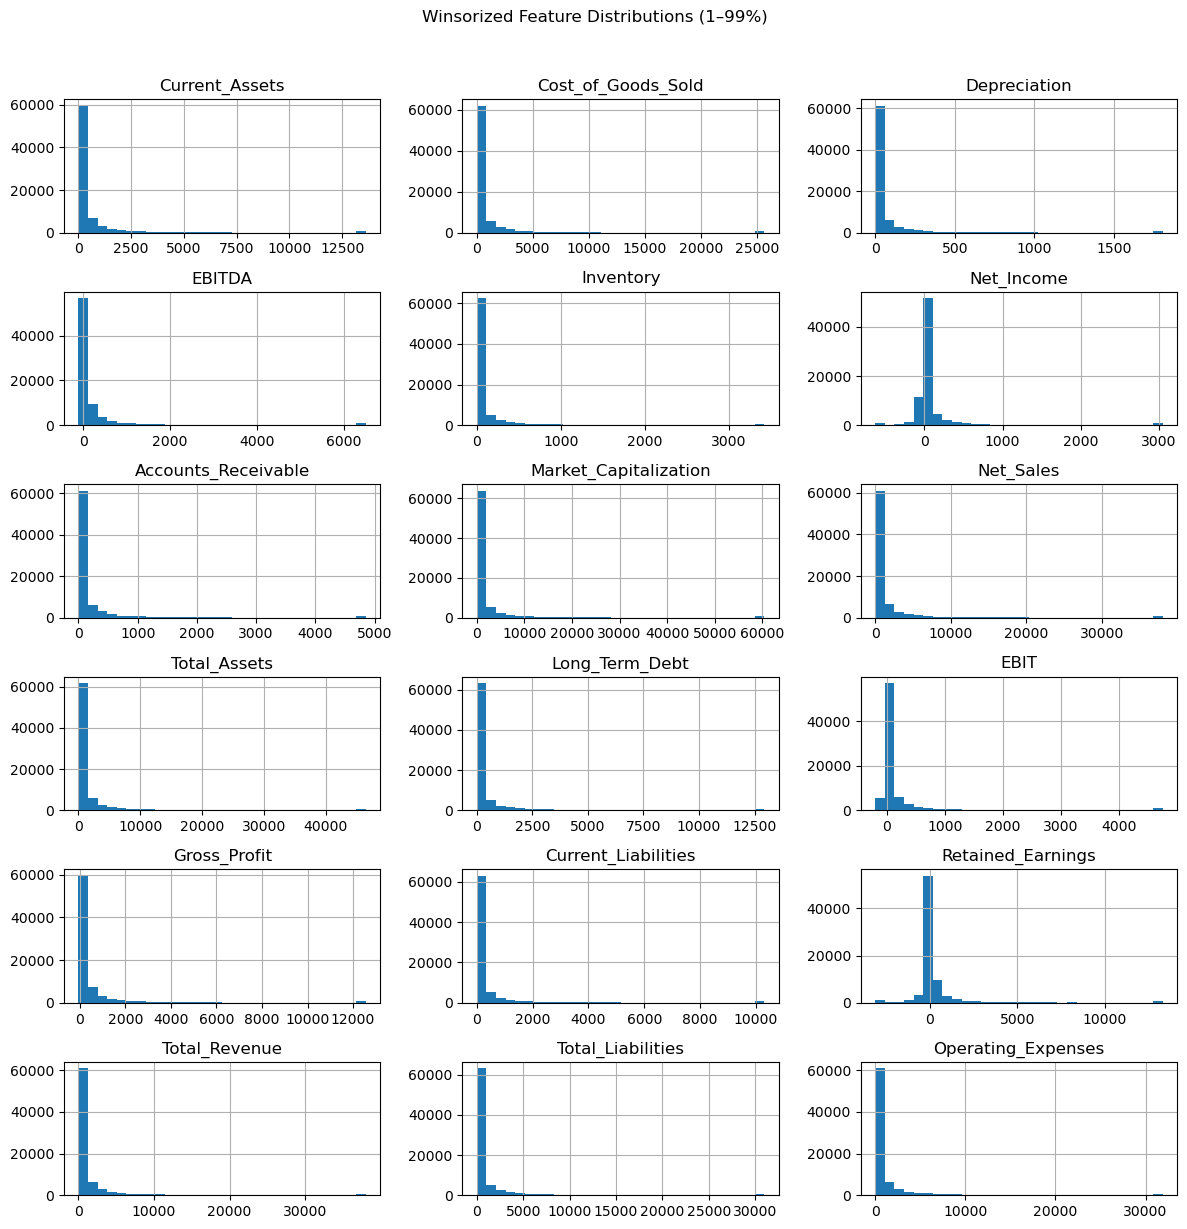

In [33]:
# 6) 퍼센타일 윈저라이징 (하위 1%, 상위 1%)
wins_df = df.copy()
for col in features:
    wins_df[col] = winsorize(wins_df[col], limits=[0.01, 0.01])

# 7) 윈저라이징 후 분포 히스토그램
plt.figure(figsize=(12,12))
wins_df[features].hist(bins=30, layout=(6,3), figsize=(12,12))
plt.suptitle('Winsorized Feature Distributions (1–99%)', y=1.02)
plt.tight_layout()
plt.show()

<Figure size 1200x1200 with 0 Axes>

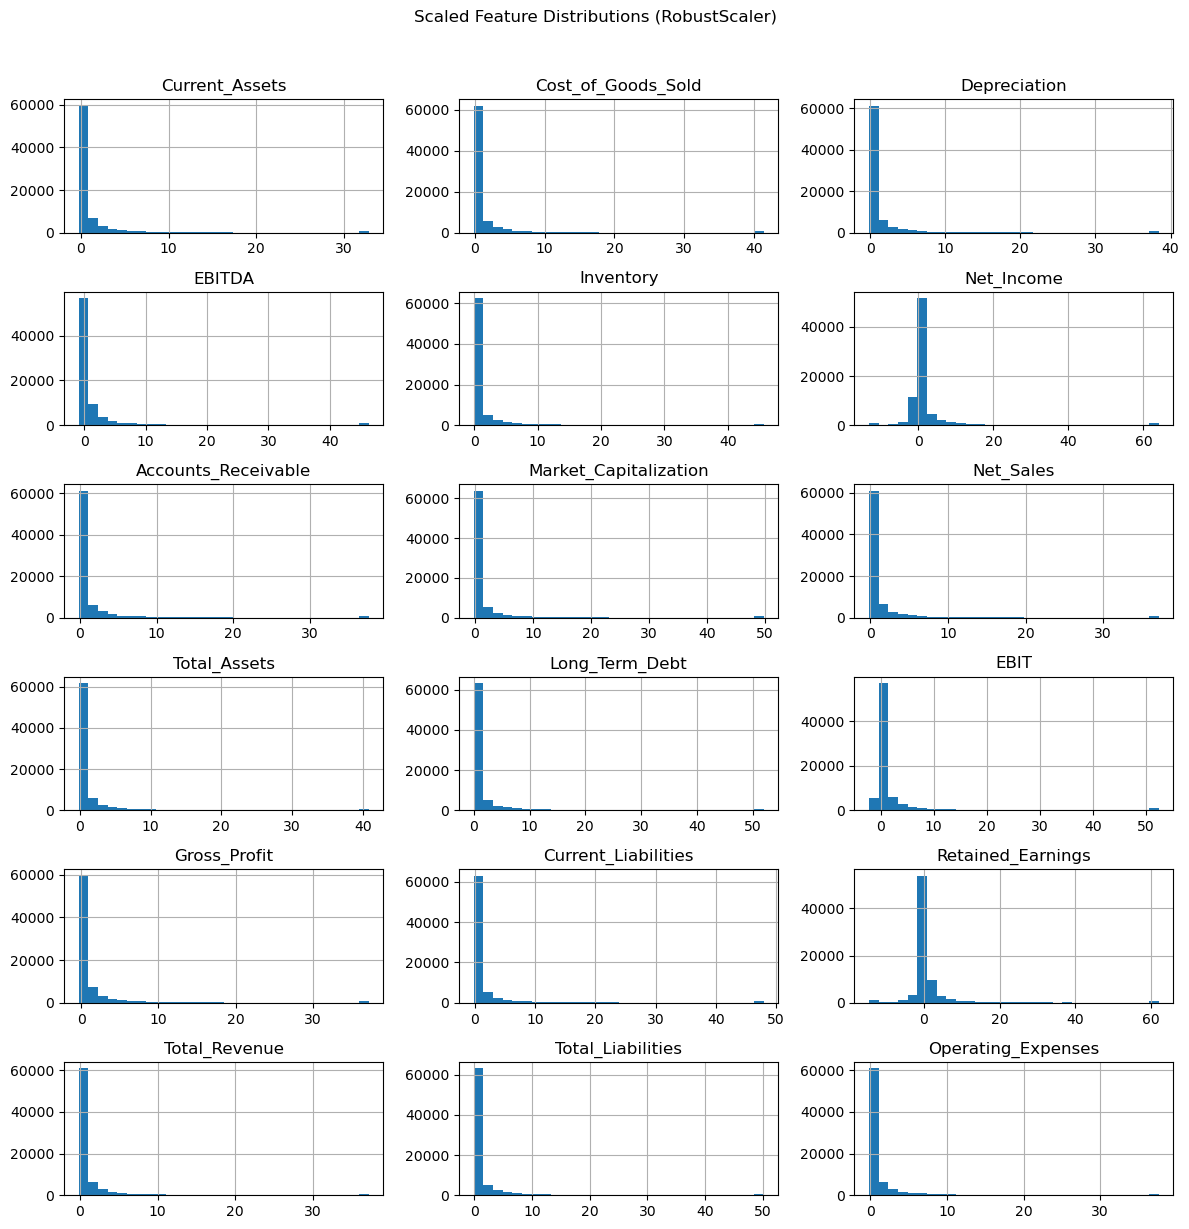

In [37]:
# 8) RobustScaler로 스케일링
scaler = RobustScaler()
scaled_array = scaler.fit_transform(wins_df[features])
scaled_df = pd.DataFrame(scaled_array, columns=features, index=wins_df.index)

# 9) 스케일링 후 분포 히스토그램
plt.figure(figsize=(12,12))
scaled_df.hist(bins=30, layout=(6,3), figsize=(12,12))
plt.suptitle('Scaled Feature Distributions (RobustScaler)', y=1.02)
plt.tight_layout()
plt.show()

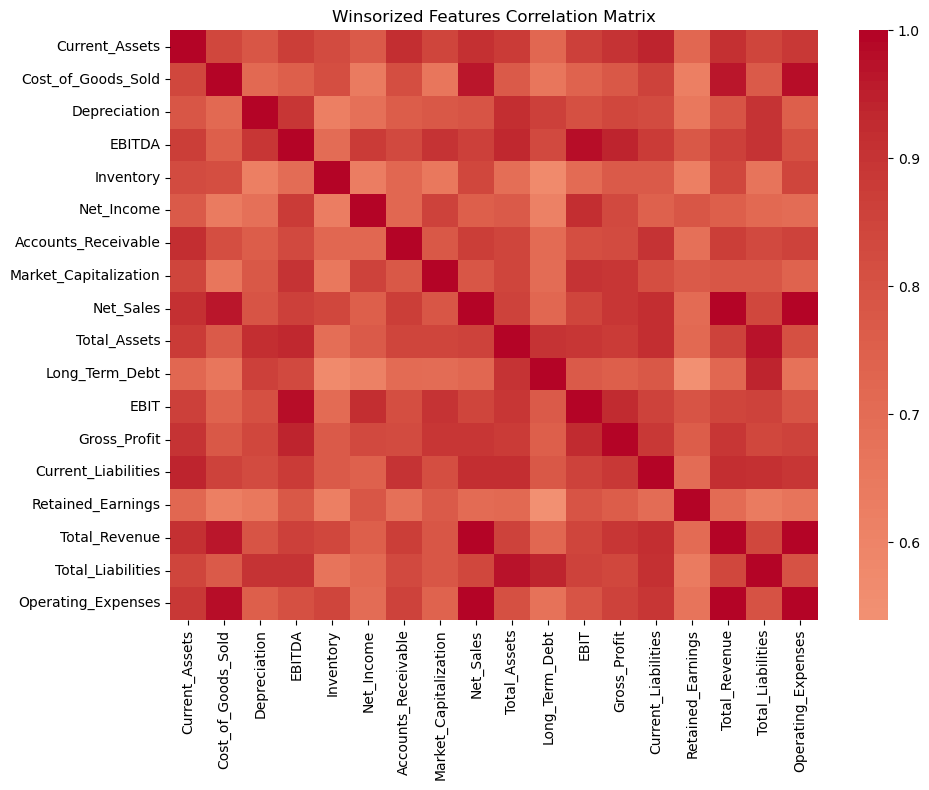

In [38]:
# 10) 윈저라이징된 데이터 상관관계 & VIF
plt.figure(figsize=(10,8))
sns.heatmap(wins_df[features].corr(), cmap='coolwarm', center=0)
plt.title('Winsorized Features Correlation Matrix')
plt.tight_layout()
plt.show()

In [39]:
# VIF 계산
X = wins_df[features].dropna()
vif_df = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print("VIF (on winsorized data):\n", vif_df.sort_values('VIF', ascending=False))

C:\Users\coghk\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF (on winsorized data):
                   feature         VIF
8               Net_Sales         inf
15          Total_Revenue         inf
17     Operating_Expenses  345.438845
3                  EBITDA  113.380637
1      Cost_of_Goods_Sold   60.631936
16      Total_Liabilities   59.173802
11                   EBIT   57.763239
9            Total_Assets   47.159194
12           Gross_Profit   26.178321
13    Current_Liabilities   23.216661
0          Current_Assets   22.313066
10         Long_Term_Debt   15.057115
2            Depreciation   13.746758
6     Accounts_Receivable    9.152572
7   Market_Capitalization    9.018434
5              Net_Income    7.868274
4               Inventory    5.040576
14      Retained_Earnings    3.522584


## Feature Engineering

In [44]:
# 1) Derived features
wins_df['debt_ratio'] = wins_df['Total_Liabilities'] / wins_df['Total_Assets']

wins_df['altman_z'] = (
    1.2 * wins_df['Current_Assets']    / wins_df['Net_Income']
  + 1.4 * wins_df['Cost_of_Goods_Sold'] / wins_df['Net_Income']
  + 3.3 * wins_df['Depreciation']      / wins_df['Net_Income']
  + 0.6 * wins_df['EBITDA']            / wins_df['Net_Income']
  + 1.0 * wins_df['Inventory']         / wins_df['Net_Income']
)


In [46]:
# 2) Scale original + derived features with RobustScaler
from sklearn.preprocessing import RobustScaler

all_features = features + ['debt_ratio', 'altman_z']
scaler_all    = RobustScaler()
scaled_array  = scaler_all.fit_transform(wins_df[all_features])
scaled_df_all = pd.DataFrame(scaled_array,
                             columns=all_features,
                             index=wins_df.index)

## Baseline Modeling: RF

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [51]:
# 1) Prepare X, y
X = scaled_df_all
y = df['default']

# 2) TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)

# 3) Initialize RF
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

In [53]:
# 4) Cross-validated ROC-AUC
cv_scores = cross_val_score(rf, X, y, cv=tss, scoring='roc_auc')
print("CV ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC:    ", cv_scores.mean())

CV ROC-AUC scores: [0.64999787 0.67214123 0.62938176 0.62137221 0.70851747]
Mean CV ROC-AUC:     0.6562821065576379


In [55]:
# 5) Fit on last fold & evaluate
for train_idx, test_idx in tss.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

rf.fit(X_train, y_train)
y_proba = rf.predict_proba(X_test)[:,1]

print("Test ROC-AUC:   ", roc_auc_score(y_test, y_proba))
print("Test Brier Score:", brier_score_loss(y_test, y_proba))

Test ROC-AUC:    0.7085174694087132
Test Brier Score: 0.05989282391519865


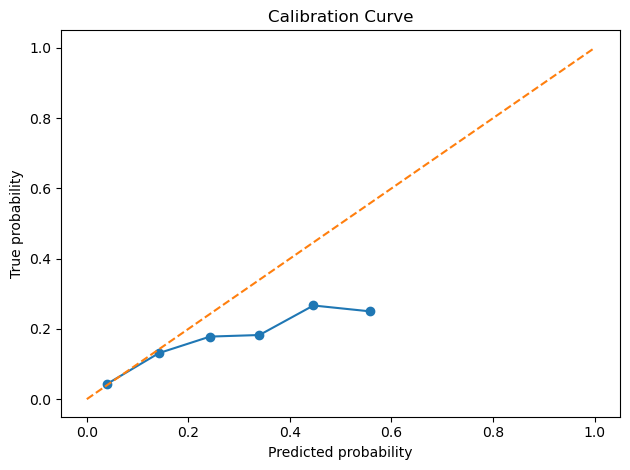

In [57]:
# 6) Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], '--')
plt.title("Calibration Curve")
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.tight_layout()
plt.show()

## Ensemble, Hyperparameter tuning

In [90]:
import optuna
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score

In [96]:
# 0) 데이터 & CV 세팅
X = scaled_df_all             # 3.2에서 생성한 스케일링된 피처셋
y = df['default']
tss3 = TimeSeriesSplit(n_splits=3)

In [98]:
# 1) XGBoost 튜닝
def objective_xgb(trial):
    params = {
        'n_estimators':    trial.suggest_int('n_estimators', 100, 300),
        'max_depth':       trial.suggest_int('max_depth', 3, 8),
        'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
    }
    model = XGBClassifier(**params,
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42,
                          n_jobs=-1)
    return cross_val_score(model, X, y, cv=tss3, scoring='roc_auc').mean()

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20, show_progress_bar=True)
best_xgb = XGBClassifier(**study_xgb.best_params,
                         use_label_encoder=False,
                         eval_metric='logloss',
                         random_state=42,
                         n_jobs=-1)

[I 2025-05-27 04:12:32,261] A new study created in memory with name: no-name-e66d7d66-1b6e-4b6a-953b-ccbb62f8b13b


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:33] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:12:34,866] Trial 0 finished with value: 0.6591824104746862 and parameters: {'n_estimators': 170, 'max_depth': 6, 'learning_rate': 0.00490956986635966}. Best is trial 0 with value: 0.6591824104746862.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:36] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:12:36,789] Trial 1 finished with value: 0.6683025994359545 and parameters: {'n_estimators': 272, 'max_depth': 3, 'learning_rate': 0.018955008674389224}. Best is trial 1 with value: 0.6683025994359545.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:39] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:12:41,879] Trial 2 finished with value: 0.6383561937115737 and parameters: {'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.0013066053557493874}. Best is trial 1 with value: 0.6683025994359545.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:43] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:12:43,785] Trial 3 finished with value: 0.6315668405883809 and parameters: {'n_estimators': 210, 'max_depth': 3, 'learning_rate': 0.001330822497603754}. Best is trial 1 with value: 0.6683025994359545.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:45] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:12:46,688] Trial 4 finished with value: 0.6456262114189367 and parameters: {'n_estimators': 159, 'max_depth': 6, 'learning_rate': 0.0019001447892990865}. Best is trial 1 with value: 0.6683025994359545.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:47] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:12:48,081] Trial 5 finished with value: 0.6648929564308533 and parameters: {'n_estimators': 112, 'max_depth': 5, 'learning_rate': 0.09498156237332664}. Best is trial 1 with value: 0.6683025994359545.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:49] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:12:50,933] Trial 6 finished with value: 0.656641784252218 and parameters: {'n_estimators': 284, 'max_depth': 4, 'learning_rate': 0.002904303041817597}. Best is trial 1 with value: 0.6683025994359545.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:53] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:12:56,481] Trial 7 finished with value: 0.6554088505246902 and parameters: {'n_estimators': 146, 'max_depth': 8, 'learning_rate': 0.0039553705206657255}. Best is trial 1 with value: 0.6683025994359545.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:12:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:01] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:13:03,775] Trial 8 finished with value: 0.6623259137520444 and parameters: {'n_estimators': 287, 'max_depth': 8, 'learning_rate': 0.003262740954892218}. Best is trial 1 with value: 0.6683025994359545.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:04] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:13:05,514] Trial 9 finished with value: 0.6691108143757201 and parameters: {'n_estimators': 235, 'max_depth': 3, 'learning_rate': 0.032041981672083365}. Best is trial 9 with value: 0.6691108143757201.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:06] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:13:07,811] Trial 10 finished with value: 0.6717280554361967 and parameters: {'n_estimators': 229, 'max_depth': 4, 'learning_rate': 0.027556076255785746}. Best is trial 10 with value: 0.6717280554361967.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:09] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:13:09,993] Trial 11 finished with value: 0.6708408693614732 and parameters: {'n_estimators': 230, 'max_depth': 4, 'learning_rate': 0.02835990719026865}. Best is trial 10 with value: 0.6717280554361967.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:11] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:13:12,734] Trial 12 finished with value: 0.6646838552267733 and parameters: {'n_estimators': 238, 'max_depth': 5, 'learning_rate': 0.044175123242266794}. Best is trial 10 with value: 0.6717280554361967.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:15] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:13:16,568] Trial 13 finished with value: 0.6692225743343037 and parameters: {'n_estimators': 239, 'max_depth': 4, 'learning_rate': 0.011549413048003283}. Best is trial 10 with value: 0.6717280554361967.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:18] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:13:18,971] Trial 14 finished with value: 0.6673779599876192 and parameters: {'n_estimators': 206, 'max_depth': 4, 'learning_rate': 0.051025532425168225}. Best is trial 10 with value: 0.6717280554361967.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:21] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:13:22,960] Trial 15 finished with value: 0.6731796166658021 and parameters: {'n_estimators': 259, 'max_depth': 5, 'learning_rate': 0.016258465386487432}. Best is trial 15 with value: 0.6731796166658021.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:25] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:13:27,793] Trial 16 finished with value: 0.6716360212806057 and parameters: {'n_estimators': 262, 'max_depth': 7, 'learning_rate': 0.008988927515616026}. Best is trial 15 with value: 0.6731796166658021.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:29] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:13:30,733] Trial 17 finished with value: 0.6722000137281202 and parameters: {'n_estimators': 260, 'max_depth': 5, 'learning_rate': 0.012858738126321021}. Best is trial 15 with value: 0.6731796166658021.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:33] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:13:35,071] Trial 18 finished with value: 0.6713535293509668 and parameters: {'n_estimators': 260, 'max_depth': 6, 'learning_rate': 0.009150137035121906}. Best is trial 15 with value: 0.6731796166658021.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4176314082.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':   trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:37] WARNING: C:\actions-runner\_work\xgboost\xgboos

[I 2025-05-27 04:13:38,416] Trial 19 finished with value: 0.672640952953763 and parameters: {'n_estimators': 299, 'max_depth': 5, 'learning_rate': 0.013846435090678285}. Best is trial 15 with value: 0.6731796166658021.


In [100]:
# 2) LightGBM 튜닝
def objective_lgb(trial):
    params = {
        'n_estimators':  trial.suggest_int('n_estimators', 100, 300),
        'num_leaves':    trial.suggest_int('num_leaves', 20, 80),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
    }
    model = LGBMClassifier(**params,
                           random_state=42,
                           n_jobs=-1)
    return cross_val_score(model, X, y, cv=tss3, scoring='roc_auc').mean()

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=20, show_progress_bar=True)
best_lgb = LGBMClassifier(**study_lgb.best_params,
                          random_state=42,
                          n_jobs=-1)

[I 2025-05-27 04:13:45,192] A new study created in memory with name: no-name-c0b6f6d7-7877-44ff-b50f-1c6e2eec422e


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 1274, number of negative: 18398
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 19672, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064762 -> initscore=-2.670080
[LightGBM] [Info] Start training from score -2.670080
[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [In

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\4040014796.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [Info] Number of positive: 3925, number of negative: 55087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 59012, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066512 -> initscore=-2.641547
[LightGBM] [Info] Start training from score -2.641547
[I 2025-05-27 

In [101]:
# 3) CatBoost 튜닝
def objective_cat(trial):
    params = {
        'iterations':    trial.suggest_int('iterations', 100, 300),
        'depth':         trial.suggest_int('depth', 3, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
    }
    model = CatBoostClassifier(**params,
                               verbose=False,
                               random_seed=42)
    return cross_val_score(model, X, y, cv=tss3, scoring='roc_auc').mean()

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=20, show_progress_bar=True)
best_cat = CatBoostClassifier(**study_cat.best_params,
                              verbose=False,
                              random_seed=42)

[I 2025-05-27 04:15:29,055] A new study created in memory with name: no-name-610efe54-8b8b-4508-9a61-09a6d362fe23


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:15:41,277] Trial 0 finished with value: 0.6679761525562977 and parameters: {'iterations': 203, 'depth': 3, 'learning_rate': 0.04292167031701914}. Best is trial 0 with value: 0.6679761525562977.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:15:54,203] Trial 1 finished with value: 0.653545249851559 and parameters: {'iterations': 212, 'depth': 3, 'learning_rate': 0.008976518216456932}. Best is trial 0 with value: 0.6679761525562977.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:16:07,492] Trial 2 finished with value: 0.672001425395783 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.014438957651551105}. Best is trial 2 with value: 0.672001425395783.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:16:25,400] Trial 3 finished with value: 0.671089296924595 and parameters: {'iterations': 272, 'depth': 4, 'learning_rate': 0.06311801542399686}. Best is trial 2 with value: 0.672001425395783.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:16:47,518] Trial 4 finished with value: 0.6665549550973506 and parameters: {'iterations': 265, 'depth': 7, 'learning_rate': 0.002890800009268914}. Best is trial 2 with value: 0.672001425395783.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:17:01,784] Trial 5 finished with value: 0.6706284807437731 and parameters: {'iterations': 207, 'depth': 5, 'learning_rate': 0.016414764888464176}. Best is trial 2 with value: 0.672001425395783.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:17:18,709] Trial 6 finished with value: 0.6702476830213536 and parameters: {'iterations': 277, 'depth': 3, 'learning_rate': 0.07530128583013304}. Best is trial 2 with value: 0.672001425395783.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:17:40,717] Trial 7 finished with value: 0.6614412846141589 and parameters: {'iterations': 222, 'depth': 8, 'learning_rate': 0.0013625701123483906}. Best is trial 2 with value: 0.672001425395783.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:17:54,658] Trial 8 finished with value: 0.6628725068508882 and parameters: {'iterations': 186, 'depth': 6, 'learning_rate': 0.003890266880280511}. Best is trial 2 with value: 0.672001425395783.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:18:07,748] Trial 9 finished with value: 0.6625007909538098 and parameters: {'iterations': 157, 'depth': 7, 'learning_rate': 0.002292380624949389}. Best is trial 2 with value: 0.672001425395783.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:18:15,063] Trial 10 finished with value: 0.6642602898695275 and parameters: {'iterations': 105, 'depth': 5, 'learning_rate': 0.01470620179253089}. Best is trial 2 with value: 0.672001425395783.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:18:34,142] Trial 11 finished with value: 0.6761112683460052 and parameters: {'iterations': 298, 'depth': 4, 'learning_rate': 0.03424621194342578}. Best is trial 11 with value: 0.6761112683460052.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:18:43,833] Trial 12 finished with value: 0.6674199080712416 and parameters: {'iterations': 150, 'depth': 4, 'learning_rate': 0.029731510570261372}. Best is trial 11 with value: 0.6761112683460052.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:19:03,094] Trial 13 finished with value: 0.6626764129652093 and parameters: {'iterations': 300, 'depth': 4, 'learning_rate': 0.007345344849004446}. Best is trial 11 with value: 0.6761112683460052.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:19:21,038] Trial 14 finished with value: 0.6753273995443757 and parameters: {'iterations': 241, 'depth': 6, 'learning_rate': 0.023108026620852474}. Best is trial 11 with value: 0.6761112683460052.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:19:39,849] Trial 15 finished with value: 0.6745992455600321 and parameters: {'iterations': 245, 'depth': 6, 'learning_rate': 0.02936521914777223}. Best is trial 11 with value: 0.6761112683460052.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:20:04,367] Trial 16 finished with value: 0.6773261381539601 and parameters: {'iterations': 298, 'depth': 7, 'learning_rate': 0.027453023068115374}. Best is trial 16 with value: 0.6773261381539601.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:20:33,569] Trial 17 finished with value: 0.6513188621973658 and parameters: {'iterations': 294, 'depth': 8, 'learning_rate': 0.09313321654863087}. Best is trial 16 with value: 0.6773261381539601.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:20:53,992] Trial 18 finished with value: 0.673098162115371 and parameters: {'iterations': 246, 'depth': 7, 'learning_rate': 0.04586202130536482}. Best is trial 16 with value: 0.6773261381539601.


C:\Users\coghk\AppData\Local\Temp\ipykernel_4464\2948157217.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),


[I 2025-05-27 04:21:17,830] Trial 19 finished with value: 0.6750756057492766 and parameters: {'iterations': 286, 'depth': 7, 'learning_rate': 0.006423813049246182}. Best is trial 16 with value: 0.6773261381539601.


In [112]:
# 4) 스태킹 앙상블 구성
estimators = [
    ('xgb', best_xgb),
    ('lgb', best_lgb),
    ('cat', best_cat)
]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=best_xgb, 
    cv=tss3,
    stack_method='predict_proba',
    n_jobs=-1
)

In [122]:
from sklearn.metrics import brier_score_loss
from sklearn.base import clone

In [124]:
# 5) 최종 결과 
# 준비
X_meta = np.zeros((len(X), len(estimators)))  # 1차 모델 OOF 예측 저장
tss = TimeSeriesSplit(n_splits=5)

# 1차 모델들로 OOF 예측 생성
for i, (name, model) in enumerate(estimators):
    for tr, te in tss.split(X):
        m = clone(model)
        m.fit(X.iloc[tr], y.iloc[tr])
        X_meta[te, i] = m.predict_proba(X.iloc[te])[:,1]

# Fold별 메타 모델 평가
fold_results = []
oof_meta = np.zeros(len(X))
for fold, (tr, te) in enumerate(tss.split(X), 1):
    meta = LogisticRegression(max_iter=1000)
    meta.fit(X_meta[tr], y.iloc[tr])

    # 이 Fold에 대한 메타 예측
    preds = meta.predict_proba(X_meta[te])[:,1]
    oof_meta[te] = preds

    # 지표 기록
    fold_results.append({
        'Fold': fold,
        'ROC-AUC': roc_auc_score(y.iloc[te], preds),
        'Brier' : brier_score_loss(y.iloc[te], preds)
    })

fold_df = pd.DataFrame(fold_results)
print("Fold별 성능:\n", fold_df)

# 전체 Combined 성능
print("\nCombined ROC-AUC:",    roc_auc_score(y, oof_meta))
print("Combined Brier Score:", brier_score_loss(y, oof_meta))

C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:30:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:30:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:30:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:30:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

[LightGBM] [Info] Number of positive: 798, number of negative: 12319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 13117, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.060837 -> initscore=-2.736789
[LightGBM] [Info] Start training from score -2.736789
[LightGBM] [Info] Number of positive: 1723, number of negative: 24507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 26230, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065688 -> initscore=-2.654892
[LightGBM] [Info] Start training from score -2.654892
[LightGBM] [Inf

## 결과가 오히려 baseline보다 안좋음. 
#### RandomizedSearchCV + 3-fold TSS, Soft-Voting Blending, Stacking Re-Tune(meta-model을 logistic regression으로 함) 이 방법들 시도해보겠음.

In [141]:
## base 모델 튜

from sklearn.model_selection import RandomizedSearchCV
# 1) 3-겹 시계열 CV 정의
tss3 = TimeSeriesSplit(n_splits=3)

# 2) 모델별 파라미터 그리드
model_configs = {
    'XGBoost': {
        'estimator': XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                   random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth':    [3, 6, 9],
            'learning_rate':[0.01, 0.1]
        }
    },
    'LightGBM': {
        'estimator': LGBMClassifier(random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators':   [100, 200, 300],
            'num_leaves':     [31, 63],
            'learning_rate':  [0.01, 0.1]
        }
    },
    'CatBoost': {
        'estimator': CatBoostClassifier(verbose=False, random_seed=42),
        'param_grid': {
            'iterations':     [100, 200, 300],
            'depth':          [4, 6, 8],
            'learning_rate':  [0.01, 0.1]
        }
    }
}

# 3) RandomizedSearchCV 실행 및 결과 수집
results = []
for name, cfg in model_configs.items():
    rs = RandomizedSearchCV(
        cfg['estimator'],
        param_distributions=cfg['param_grid'],
        n_iter=6,
        cv=tss3,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42
    )
    rs.fit(X, y)
    results.append({
        'Model': name,
        'Best Params': rs.best_params_,
        'Mean CV ROC-AUC': rs.best_score_
    })

# 4) 결과 
results_df = pd.DataFrame(results)
print(results_df)

C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:44:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 5220, number of negative: 73462
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 78682, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066343 -> initscore=-2.644271
[LightGBM] [Info] Start training from score -2.644271
      Model                                        Best Params  \
0   XGBoost  {'n_estimators': 300, 'max_depth': 6, 'learnin...   
1  LightGBM  {'num_leaves': 63, 'n_estimators': 300, 'learn...   
2  CatBoost  {'learning_rate': 0.1, 'iterations': 100, 'dep...   

   Mean CV ROC-AUC  
0         0.672311  
1         0.672256  
2         0.674257  


In [145]:
# soft-voting blending: 각 모델의 cv auc모델을 가중치로 활용했음
from sklearn.ensemble import VotingClassifier

# 모델별 CV AUC 추출 (가중치용)
weights = []
for m in [best_xgb, best_lgb, best_cat]:
    scores = cross_val_score(m, X, y, cv=tss3, scoring='roc_auc')
    weights.append(scores.mean())

vot = VotingClassifier(
    estimators=[('xgb',best_xgb),('lgb',best_lgb),('cat',best_cat)],
    voting='soft',
    weights=weights,
    n_jobs=-1
)
vot.fit(X_train, y_train)
print("Soft-Voting ROC-AUC:", roc_auc_score(y_test, vot.predict_proba(X_test)[:,1]))

C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:46:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:46:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:46:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 1274, number of negative: 18398
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 19672, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064762 -> initscore=-2.670080
[LightGBM] [Info] Start training from score -2.670080
[LightGBM] [Info] Number of positive: 2549, number of negative: 36793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 39342, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064791 -> initscore=-2.669606
[LightGBM] [Info] Start training from score -2.669606
[LightGBM] [In

In [146]:
# Stacking Re-Tune
from sklearn.model_selection import KFold

kf5 = KFold(n_splits=5, shuffle=False)

stack = StackingClassifier(
    estimators=[('xgb',best_xgb),('lgb',best_lgb),('cat',best_cat)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=kf5,
    stack_method='predict_proba',
    n_jobs=-1
)
# 학습
stack.fit(X_train, y_train)
# 보정
cal_stack = CalibratedClassifierCV(stack, method='isotonic', cv=kf5)
cal_stack.fit(X_train, y_train)

y_cal = cal_stack.predict_proba(X_test)[:,1]
print("Stack+Cal ROC-AUC:", roc_auc_score(y_test, y_cal))
print("Stack+Cal Brier:",  brier_score_loss(y_test, y_cal))

Stack+Cal ROC-AUC: 0.7430584868403665
Stack+Cal Brier: 0.05803674235955038


## Soft-Voting Blending과 Stacking + Calibrated으로 결정. 세부 분석

In [150]:
from sklearn.metrics import mean_absolute_error
# 1) 유틸 함수 정의
def weighted_mae(y_true, y_pred, w=None):
    if w is None:
        return mean_absolute_error(y_true, y_pred)
    return np.sum(w * np.abs(y_true - y_pred)) / np.sum(w)

def recall_at_fpr(y_true, y_scores, fpr_threshold=0.1):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    idx = np.where(fpr <= fpr_threshold)[0]
    if idx.size == 0:
        return 0.0
    thresh = thresholds[idx[-1]]
    preds = (y_scores >= thresh).astype(int)
    return recall_score(y_true, preds)

# 2) 모델 예측 확률 (사전에 vot, cal_stack, X_test 정의)
y_pred_vot = vot.predict_proba(X_test)[:,1]
y_pred_cal = cal_stack.predict_proba(X_test)[:,1]

# 3) 메트릭 계산 및 정리
records = []
for model_name, y_pred in [('Soft-Voting', y_pred_vot), ('Stack+Cal', y_pred_cal)]:
    records.append({
        'Model': model_name,
        'ROC-AUC': roc_auc_score(y_test, y_pred),
        'Brier': brier_score_loss(y_test, y_pred),
        'WMAE': weighted_mae(y_test, y_pred),
        'Recall@FPR0.05': recall_at_fpr(y_test, y_pred, fpr_threshold=0.05),
        'Recall@FPR0.10': recall_at_fpr(y_test, y_pred, fpr_threshold=0.10),
    })

# 4) 결과 출력
results_df = pd.DataFrame(records)
print(results_df.to_markdown(index=False))

| Model       |   ROC-AUC |     Brier |     WMAE |   Recall@FPR0.05 |   Recall@FPR0.10 |
|:------------|----------:|----------:|---------:|-----------------:|-----------------:|
| Soft-Voting |  0.740613 | 0.0577854 | 0.122181 |         0.236994 |         0.354913 |
| Stack+Cal   |  0.743058 | 0.0580367 | 0.123958 |         0.240462 |         0.365318 |


#### 부도 확률을 등급(rating) 구간으로 나누어 역검증할 때는, 단순한 순위화(AUC)보다 확률 자체의 정확도(보정력 / calibration) 가 더 중요하다.

#### Soft-Voting이 Brier Score(0.0578 vs. 0.0580)와 WMAE(0.1222 vs. 0.1240)에서 소폭 우위였기 때문에 확률 구간별 실제 부도율(Observed Default Rate)과의 정합성을 살펴볼 때도 Soft-Voting의 예측값이 더 잘 맞을 가능성이 크다고 생각함.

## 심화 모델링: 회귀+분류 혼합 모델은 하지 않도록 하겠음. Soft-voting으로 결정

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, brier_score_loss,
    mean_absolute_error, recall_score, roc_curve, confusion_matrix
)
from sklearn.calibration import calibration_curve
import warnings

## 테스트 결과 다시 확인하고 평가, 해석

C:\Users\coghk\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:36:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Final Test Metrics (Soft-Voting) ===
| Metric         |     Value |
|:---------------|----------:|
| ROC-AUC        | 0.740613  |
| Brier          | 0.0577854 |
| WMAE           | 0.122181  |
| Recall@FPR0.05 | 0.236994  |
| Recall@FPR0.10 | 0.354913  |


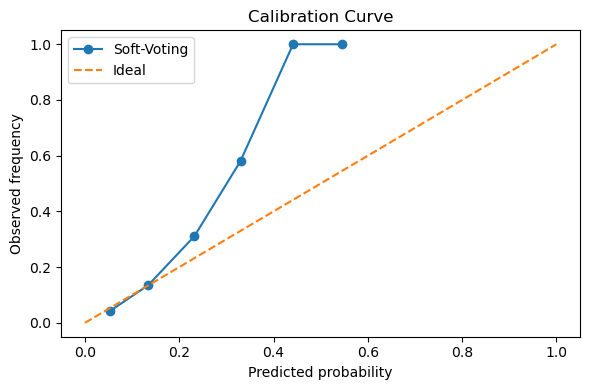

Top 5 thresholds by minimal cost:
|   threshold |   cost |   youden |
|------------:|-------:|---------:|
|        0.11 |   6564 | 0.265909 |
|        0.1  |   6594 | 0.255387 |
|        0.09 |   6671 | 0.246838 |
|        0.08 |   6731 | 0.229392 |
|        0.12 |   6759 | 0.27775  |

Top 5 thresholds by Youden's J statistic:
|   threshold |   cost |   youden |
|------------:|-------:|---------:|
|        0.36 |   8570 | 0.352162 |
|        0.32 |   8487 | 0.351925 |
|        0.37 |   8570 | 0.351694 |
|        0.33 |   8525 | 0.350572 |
|        0.38 |   8570 | 0.350397 |


In [177]:
best_xgb.fit(X_train, y_train)

# 1) 유틸 함수
def weighted_mae(y_true, y_pred, w=None):
    if w is None:
        return mean_absolute_error(y_true, y_pred)
    return np.sum(w * np.abs(y_true - y_pred)) / np.sum(w)

def recall_at_fpr(y_true, y_scores, fpr_threshold=0.1):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    idx = np.where(fpr <= fpr_threshold)[0]
    if idx.size == 0:
        return 0.0
    thresh = thresholds[idx[-1]]
    return recall_score(y_true, (y_scores >= thresh).astype(int))

# 2) 최종 테스트 예측 확률
y_pred_prob = vot.predict_proba(X_test)[:,1]

# 3) 주요 지표 계산
metrics = {
    'Metric': ['ROC-AUC', 'Brier', 'WMAE', 'Recall@FPR0.05', 'Recall@FPR0.10'],
    'Value': [
        roc_auc_score(y_test, y_pred_prob),
        brier_score_loss(y_test, y_pred_prob),
        weighted_mae(y_test, y_pred_prob),
        recall_at_fpr(y_test, y_pred_prob, fpr_threshold=0.05),
        recall_at_fpr(y_test, y_pred_prob, fpr_threshold=0.10)
    ]
}
print("=== Final Test Metrics (Soft-Voting) ===")
print(pd.DataFrame(metrics).to_markdown(index=False))

# 4) 보정 곡선
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o', label='Soft-Voting')
plt.plot([0,1],[0,1],'--', label='Ideal')
plt.title('Calibration Curve')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.legend()
plt.tight_layout()
plt.show()

# 5) 임계값(cost-benefit) 분석
cost_fp, cost_fn = 1, 10
thresholds = np.linspace(0,1,101)
rows = []
for thr in thresholds:
    preds = (y_pred_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    cost = fp * cost_fp + fn * cost_fn
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    idx = np.where(fpr <= thr)[0]
    youden = (tpr[idx[-1]] - fpr[idx[-1]]) if idx.size else 0
    rows.append({'threshold':thr, 'cost':cost, 'youden':youden})

cost_df = pd.DataFrame(rows)
print("Top 5 thresholds by minimal cost:")
print(cost_df.nsmallest(5, 'cost').to_markdown(index=False))
print("\nTop 5 thresholds by Youden's J statistic:")
print(cost_df.nlargest(5, 'youden').to_markdown(index=False))

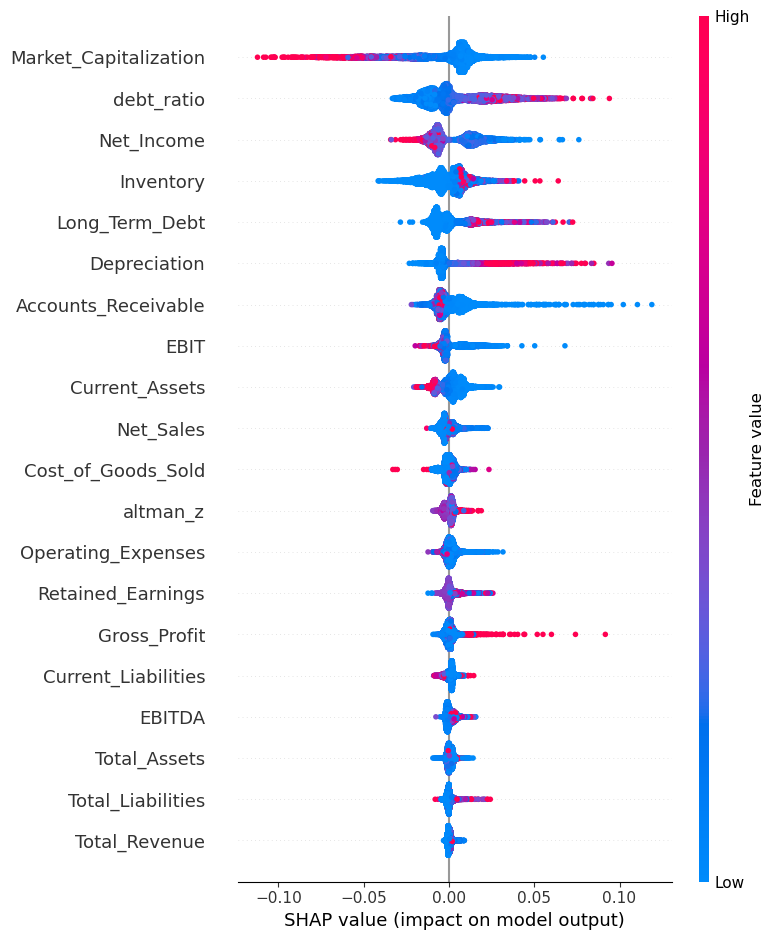

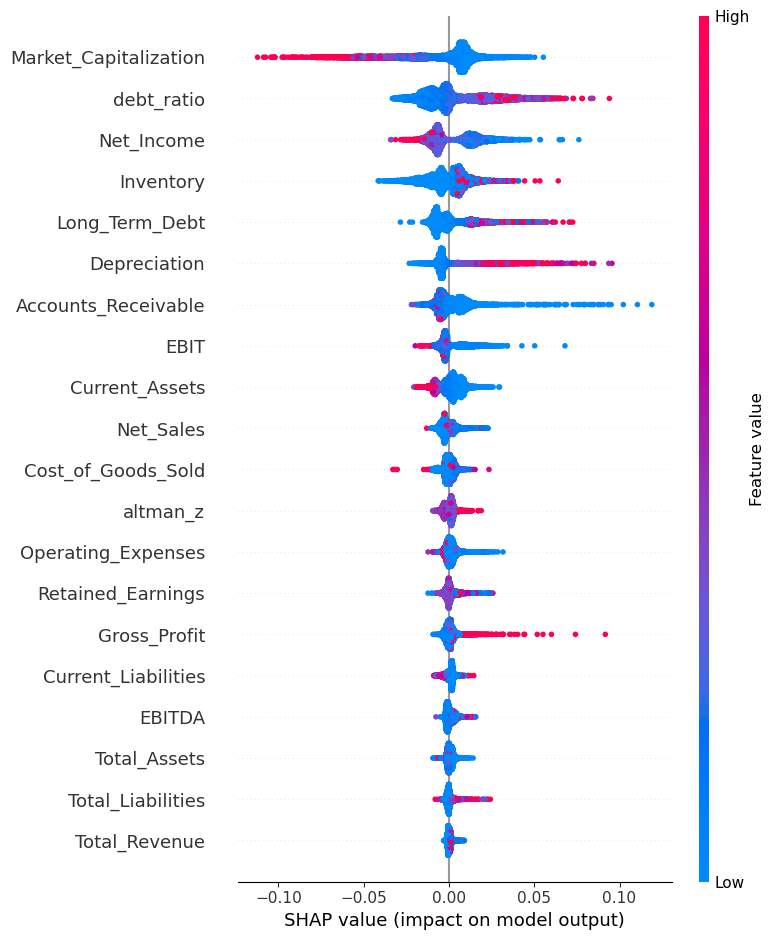

In [179]:
## SHAP 요약

# 1) 앙상블(Soft-Voting)로 전체 훈련셋 예측 확률 생성
ens_train = vot.predict_proba(X_train)[:,1]

# 2) XGBRegressor 를 서포팅 모델로 학습
surrogate = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
surrogate.fit(X_train, ens_train)

# 3) SHAP TreeExplainer 적용
explainer = shap.TreeExplainer(surrogate)
shap_values = explainer.shap_values(X_test)

# 4) 요약 플롯
plt.title("SHAP Summary for Soft‐Voting Surrogate")
shap.summary_plot(shap_values, X_test, show=True)# 1) 앙상블(Soft-Voting)로 전체 훈련셋 예측 확률 생성
ens_train = vot.predict_proba(X_train)[:,1]

# 2) XGBRegressor 를 서포팅 모델로 학습
surrogate = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
surrogate.fit(X_train, ens_train)

# 3) SHAP TreeExplainer 적용
explainer = shap.TreeExplainer(surrogate)
shap_values = explainer.shap_values(X_test)

# 4) 요약 플롯
plt.title("SHAP Summary for Soft‐Voting Surrogate")
shap.summary_plot(shap_values, X_test, show=True)

ROC-AUC 0.74: 무작위(0.5) 대비 훨씬 높아, 기업별 부도 위험 순위화 성능이 우수.

Brier Score 0.0578: 예측 확률의 보정도(calibration)가 전반적으로 잘 맞.

WMAE 0.1222: 실제 0/1 라벨과 확률 예측 간 절대 오차가 평균 0.12 수준.

Recall@FPR0.05≈0.24, Recall@FPR0.10≈0.35:

거짓양성률 5% 아래에서 전체 부도 기업 약 24%를,

10% 이하에서는 약 35%를 찾아냄

Calibration Curve
0.0–0.2 구간: 대체로 이상적(주황 점선)과 근접

0.2–0.6 구간: 실제 관측 빈도가 예측 확률보다 낮음 ⇒ 중간·고위험 구간에서 확률이 소폭 과대추정(over-estimate)

Threshold Cost–Benefit 분석
최소 비용(cost) 기준: 0.11일 때 FP·FN을 합산한 비용 최소

Youden’s J 기준: 0.32–0.37 구간에서 민감도 – 특이도가 최대

추천 절충안:

비용 최적화가 우선이라면 0.10–0.12 사이

균형(민감도·특이도) 중시 시 0.32–0.37 사이

주요 피처 순위
Market_Capitalization

붉은 점(값이 큰 기업)은 대부분 SHAP 값이 음수(왼쪽) → 시가총액이 클수록 부도 확률을 크게 낮추는 요인

debt_ratio

빨간(높은 부채비율) 점들이 오른쪽으로 퍼져 있음 → 부채비율이 높으면 부도 확률을 올리는 주 요인

Net_Income

순이익이 클 때가 SHAP 값 마이너스(부도 확률 ↓), 작을 때가 플러스(부도 확률 ↑)

Inventory, Long_Term_Debt, Depreciation

재고자산·장기부채·감가상각비도 각각 높을 때(붉은)이 부도 확률을 올리는 경향이 뚜렷

그 외

Accounts_Receivable, EBIT, Current_Assets 등도 중간 영향도를 보임

가장 영향력이 작은 쪽에는 Total_Revenue, Total_Liabilities 등이 위치

In [258]:
# app.py
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, roc_curve
import joblib

@st.cache_resource
def load_model():
    return joblib.load("soft_voting_model.pkl")
col_mapping_en = {
    'X1':  'Current_Assets', 'X2':  'Cost_of_Goods_Sold', 'X3':  'Depreciation',
    'X4':  'EBITDA', 'X5':  'Inventory', 'X6':  'Net_Income', 'X7':  'Accounts_Receivable',
    'X8':  'Market_Capitalization', 'X9':  'Net_Sales', 'X10': 'Total_Assets',
    'X11': 'Long_Term_Debt','X12': 'EBIT', 'X13': 'Gross_Profit', 'X14': 'Current_Liabilities',
    'X15': 'Retained_Earnings','X16': 'Total_Revenue','X17': 'Total_Liabilities','X18': 'Operating_Expenses',
}
BASE_FEATURES = list(col_mapping_en.values())
DERIVED = ['debt_ratio', 'altman_z']
FEATURE_COLUMNS = BASE_FEATURES + DERIVED

# 0) 모델·데이터 로드 (직접 수정)
@st.cache(allow_output_mutation=True)
def load_data():
    df = pd.read_csv("./american_bankruptcy.csv")
    df.rename(columns=col_mapping_en, inplace=True)
    df['default'] = df['status_label'].map({'failed':1, 'alive':0})
    df['debt_ratio'] = df['Total_Liabilities'] / df['Total_Assets']
    df['working_capital'] = df['Current_Assets'] - df['Current_Liabilities']
    df['altman_z'] = (
        1.2 * df['working_capital'] / df['Total_Assets'] +
        1.4 * df['Retained_Earnings'] / df['Total_Assets'] +
        3.3 * df['EBIT'] / df['Total_Assets'] +
        0.6 * df['Market_Capitalization'] / df['Total_Liabilities'] +
        1.0 * df['Net_Sales'] / df['Total_Assets']
    )
    # (working_capital 컬럼은 더 이상 필요없으면 drop)
    df.drop(columns=['working_capital'], inplace=True)

    X = df[FEATURE_COLUMNS]
    y = df["default"]
    return X, y

model = load_model()
X, y = load_data()

st.title("Credit Risk Dashboard")

# 1) Threshold slider
threshold = st.sidebar.slider(
    "Select probability threshold",
    0.0, 1.0, 0.1, step=0.01
)

# 2) 예측 확률 & 등급 매핑
probs = model.predict_proba(X)[:,1]
df = X.copy()
df["default_prob"] = probs

# 3) Dynamic grade cuts (5,15,30,50,70,90 percentile on validation set saved earlier)
cuts = st.session_state.get("cuts", [0.05,0.15,0.30,0.50,0.70,0.90])
labels = ["AAA","AA+","AA","A+","A","BBB","BB"]
df["grade"] = pd.cut(probs,
                     bins=[-1.0]+cuts+[1.0],
                     labels=labels,
                     include_lowest=True)

# 4) Risk Gauge (Plotly gauge)
avg_prob = probs.mean()
fig_gauge = px.pie(
    names=["Default","Survival"],
    values=[avg_prob, 1-avg_prob],
    hole=0.7,
    title="Overall Default Probability"
)
st.plotly_chart(fig_gauge, use_container_width=True)

# 5) Calibration Curve
st.subheader("📈 Calibration Curve")
prob_true, prob_pred = calibration_curve(y, probs, n_bins=10)
fig_cal = px.line(
    x=prob_pred, y=prob_true, markers=True,
    labels={"x":"Predicted","y":"Observed"},
    title="Calibration Curve"
)
fig_cal.add_scatter(x=[0,1], y=[0,1], mode="lines", line=dict(dash="dash"))
st.plotly_chart(fig_cal, use_container_width=True)

# 6) Grade distribution & observed vs expected
st.subheader("Grade Verification")
grp = df.groupby("grade").agg(
    count=("default_prob","size"),
    observed_rate=("default_prob", lambda x: y[x.index].mean()),
    expected_rate=("default_prob","mean")
).reset_index()
st.dataframe(grp)

fig_bar = px.bar(
    grp.melt(id_vars="grade", value_vars=["observed_rate","expected_rate"]),
    x="grade", y="value", color="variable",
    barmode="group", title="Observed vs. Expected Default Rate by Grade"
)
st.plotly_chart(fig_bar, use_container_width=True)

# 7) Confusion matrix at slider threshold
st.subheader("Confusion Matrix at Threshold")
pred_label = (probs >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y, pred_label).ravel()
cm = pd.DataFrame([[tn, fp],[fn, tp]], index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"])
st.table(cm)


2025-05-27 06:55:15.454 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 06:55:15.455 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 06:55:15.456 
`st.cache` is deprecated and will be removed soon. Please use one of Streamlit's new
caching commands, `st.cache_data` or `st.cache_resource`. More information
[in our docs](https://docs.streamlit.io/develop/concepts/architecture/caching).

**Note**: The behavior of `st.cache` was updated in Streamlit 1.36 to the new caching
logic used by `st.cache_data` and `st.cache_resource`. This might lead to some problems
or unexpected behavior in certain edge cases.

2025-05-27 06:55:15.457 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 06:55:15.459 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-2

DeltaGenerator()

## STEAMLIT니까 앱실행해서 보시면 됩니다

=== Grade Verification ===
| grade   |   count |   obs_rate |   exp_rate |       WMAE |
|:--------|--------:|-----------:|-----------:|-----------:|
| A+      |     524 | 0.00381679 |  0.0115104 | 0.00769361 |
| A0      |    1040 | 0.00576923 |  0.0131289 | 0.00735963 |
| B+      |    1955 | 0.00255754 |  0.0166433 | 0.0140858  |
| B0      |    2448 | 0.00939542 |  0.0227213 | 0.0133259  |
| C+      |    2433 | 0.0238389  |  0.0443222 | 0.0204834  |
| C0      |    2403 | 0.0382855  |  0.0902991 | 0.0520136  |
| D       |    1479 | 0.0682894  |  0.183608  | 0.115319   |


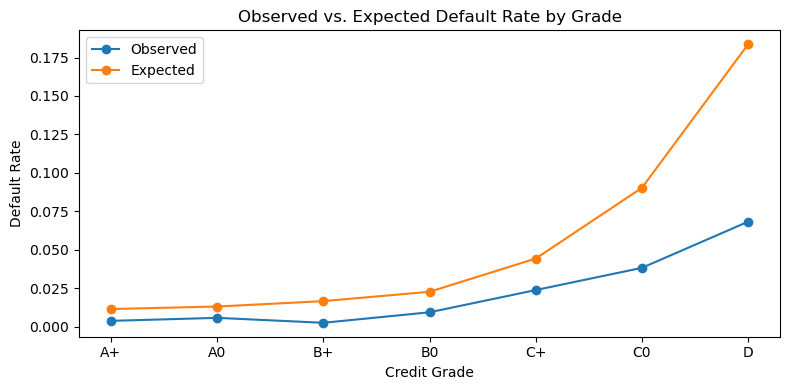

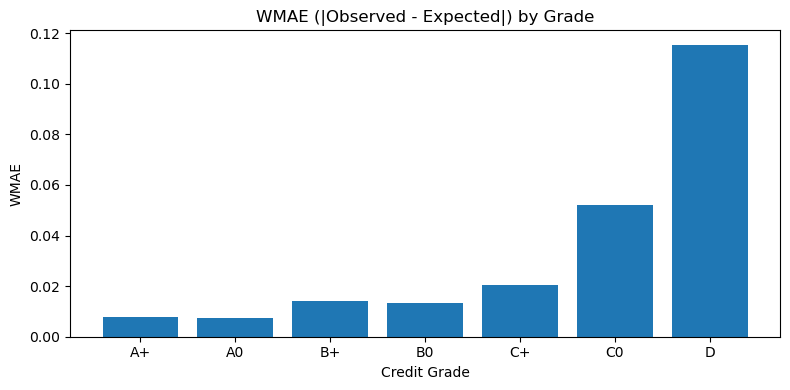

In [256]:
# 원본 df 로드 + 컬럼명 변경 + 파생변수까지 모두 포함
df = pd.read_csv("./american_bankruptcy.csv")
df.rename(columns=col_mapping_en, inplace=True)
df['default']   = df['status_label'].map({'failed':1,'alive':0})
df['debt_ratio']= df['Total_Liabilities']/df['Total_Assets']
# Altman Z-Score 예시
df['working_capital'] = df['Current_Assets']-df['Current_Liabilities']
df['altman_z']  = (
    1.2*df['working_capital']/df['Total_Assets'] +
    1.4*df['Retained_Earnings']/df['Total_Assets'] +
    3.3*df['EBIT']/df['Total_Assets'] +
    0.6*df['Market_Capitalization']/df['Total_Liabilities'] +
    1.0*df['Net_Sales']/df['Total_Assets']
)
df.drop(columns=['working_capital','status_label'], inplace=True)

# 특성(feature)과 라벨 분리
FEATURE_COLUMNS = BASE_FEATURES + ['debt_ratio','altman_z']
X = df[FEATURE_COLUMNS]
y = df['default']

# 연도 기준으로 분할 — 반드시 원본 df 에서!
mask_val   = df['year'].between(2012,2014)
mask_test  = df['year'].between(2015,2018)

X_val, y_val   = X[mask_val], y[mask_val]
X_test, y_test = X[mask_test], y[mask_test]

# 1) Validation 세트에서 동적 cut 계산 (예: 5,15,30,50,70,90 percentile)
val_probs = model.predict_proba(X_val)[:,1]
percentiles = [5,15,30,50,70,90]
cuts = np.percentile(val_probs, percentiles)

# 2) map_prob_to_rating 함수
def map_prob_to_rating(p, cuts):
    p5, p15, p30, p50, p70, p90 = cuts
    if p < p5:   return 'A+'
    elif p < p15: return 'A0'
    elif p < p30: return 'B+'
    elif p < p50: return 'B0'
    elif p < p70: return 'C+'
    elif p < p90: return 'C0'
    else:         return 'D'

# 3) 테스트 세트 등급 할당
test_probs = model.predict_proba(X_test)[:,1]
df_test = pd.DataFrame({
    'prob': test_probs,
    'default': y_test
})
df_test['grade'] = df_test['prob'].apply(lambda x: map_prob_to_rating(x, cuts))

# 4) 등급별 관측·예측 부도율 & WMAE
grouped = df_test.groupby('grade').agg(
    count=('default','size'),
    obs_rate=('default','mean'),
    exp_rate=('prob','mean')
).reset_index()
grouped['WMAE'] = (grouped['obs_rate'] - grouped['exp_rate']).abs()

# 5) 혼동행렬 형태 요약
#   grade를 이진(부도/비부도)으로 보면 아님, 그냥 등급별 accuracy 아님
#   but 등급별 부도예측 vs 실제 부도율 차이만 보셔도 충분

print("=== Grade Verification ===")
print(grouped.to_markdown(index=False))

# 6) 시각화 (matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(grouped['grade'], grouped['obs_rate'], marker='o', label='Observed')
plt.plot(grouped['grade'], grouped['exp_rate'], marker='o', label='Expected')
plt.title('Observed vs. Expected Default Rate by Grade')
plt.xlabel('Credit Grade')
plt.ylabel('Default Rate')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.bar(grouped['grade'], grouped['WMAE'])
plt.title('WMAE (|Observed - Expected|) by Grade')
plt.xlabel('Credit Grade')
plt.ylabel('WMAE')
plt.tight_layout()
plt.show()
